In [ ]:
import pandas as pd
# Load the dataset
data = pd.read_csv("data_analyst_jobs.csv")

In [ ]:
# Inspect the dataset
print(data.head())
print(data.info())

   Unnamed: 0                                          Job Title  \
0           0  Data Analyst, Center on Immigration and Justic...   
1           1                               Quality Data Analyst   
2           2  Senior Data Analyst, Insights & Analytics Team...   
3           3                                       Data Analyst   
4           4                             Reporting Data Analyst   

              Salary Estimate  \
0  $37K-$66K (Glassdoor est.)   
1  $37K-$66K (Glassdoor est.)   
2  $37K-$66K (Glassdoor est.)   
3  $37K-$66K (Glassdoor est.)   
4  $37K-$66K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Are you eager to roll up your sleeves and harn...     3.2   
1  Overview\n\nProvides analytical and technical ...     3.8   
2  We’re looking for a Senior Data Analyst who ha...     3.4   
3  Requisition NumberRR-0001939\nRemote:Yes\nWe c...     4.1   
4  ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...     3.9   

       

In [ ]:
# Check for duplicates
print(f"Duplicate rows: {data.duplicated().sum()}")
# General statistics
print(data.describe(include='all'))
# Value counts for categorical columns
for col in ['Job Title', 'Type of ownership', 'Industry',
'Sector']:
    print(data[col].value_counts().head())

Duplicate rows: 0
        Unnamed: 0     Job Title             Salary Estimate  \
count    2253.0000          2253                        2253   
unique         NaN          1272                          90   
top            NaN  Data Analyst  $41K-$78K (Glassdoor est.)   
freq           NaN           405                          57   
mean     1126.0000           NaN                         NaN   
std       650.5294           NaN                         NaN   
min         0.0000           NaN                         NaN   
25%       563.0000           NaN                         NaN   
50%      1126.0000           NaN                         NaN   
75%      1689.0000           NaN                         NaN   
max      2252.0000           NaN                         NaN   

                                          Job Description       Rating  \
count                                                2253  2253.000000   
unique                                               2253        

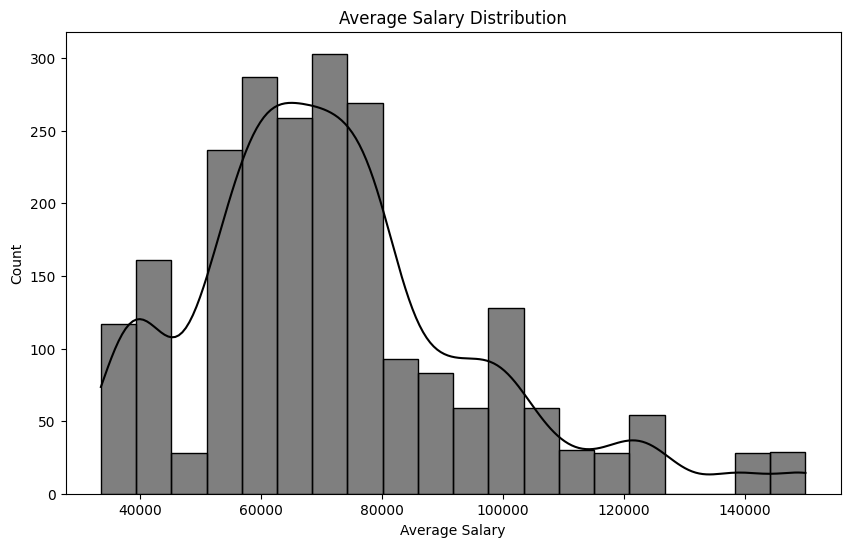

In [738]:
import matplotlib.pyplot as plt
import seaborn as sns
# Salary distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Avg Salary'], kde=True, bins=20, color='black')
plt.title("Average Salary Distribution")
plt.xlabel("Average Salary")
plt.show()

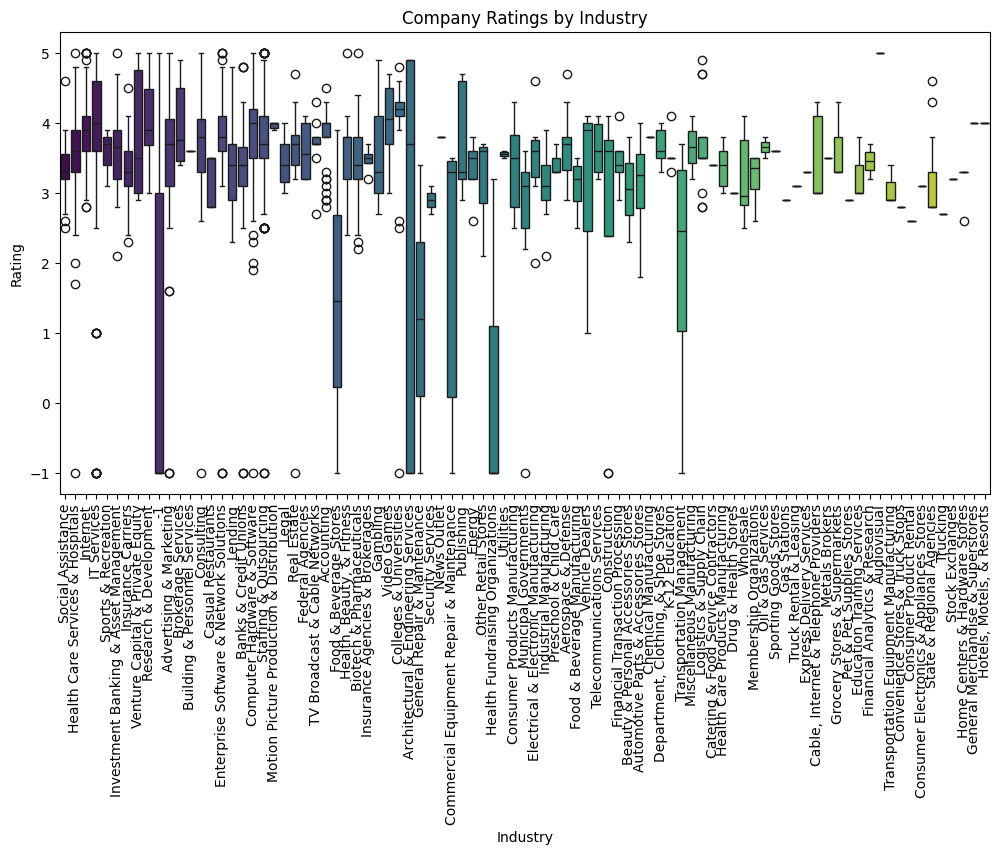

In [735]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Industry', y='Rating', data=data, palette='viridis')
plt.xticks(rotation=90)
plt.title("Company Ratings by Industry")
plt.show()

In [ ]:
# Check missing values
print(data.isnull().sum())
# Fill missing numerical values
data['Rating'] = data['Rating'].fillna(data['Rating'].median())
# Drop columns with > 30% missing data
threshold = len(data) * 0.3
data = data.dropna(thresh=threshold, axis=1)
# Forward-fill categorical values
categorical_cols = ['Company Name', 'Industry', 'Sector', 'Type of ownership']
data[categorical_cols] = data[categorical_cols].ffill()

Unnamed: 0           0
Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         1
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
Easy Apply           0
dtype: int64


In [ ]:
import re

# More robust salary parsing function
def parse_salary_range(salary_str):
    if pd.isna(salary_str) or salary_str == '-1':
        return None, None

    # Clean the string: convert 'k' to '000', remove '$' and ',' and leading/trailing whitespace
    salary_str = salary_str.lower().replace('k', '000').replace('$', '').replace(',', '').strip()

    min_sal = None
    max_sal = None

    # Handle 'per hour' salaries first
    if 'per hour' in salary_str:
        numbers = [float(s) for s in re.findall(r'\d+', salary_str)]
        if len(numbers) >= 1:
            hourly_min = numbers[0]
            hourly_max = numbers[-1] if len(numbers) > 1 else numbers[0]
            # Convert to annual salary (assuming 2080 working hours in a year)
            min_sal = hourly_min * 2080
            max_sal = hourly_max * 2080

    # Handle annual salary ranges (e.g., '37000-66000')
    elif '-' in salary_str:
        numbers = [float(s) for s in re.findall(r'\d+', salary_str)]
        if len(numbers) >= 2:
            min_sal = numbers[0]
            max_sal = numbers[1]
        elif len(numbers) == 1: # Handle cases like '50000-' where only one number is explicitly given
            min_sal = numbers[0]
            max_sal = numbers[0]

    # Handle single annual salary (e.g., '100000')
    else:
        numbers = [float(s) for s in re.findall(r'\d+', salary_str)]
        if len(numbers) == 1:
            min_sal = numbers[0]
            max_sal = numbers[0]

    return min_sal, max_sal

# Apply the parsing function
# NOTE: If 'Salary Estimate' column is missing, you must rerun data loading cells (e.g., h54riResXc1g or S8Kw6W8DTiEO)
# and all subsequent cells to ensure the 'Salary Estimate' column is available in the 'data' DataFrame.
parsed_salaries = data['Salary Estimate'].apply(lambda x: parse_salary_range(x))
data['Min Salary'] = parsed_salaries.apply(lambda x: x[0])
data['Max Salary'] = parsed_salaries.apply(lambda x: x[1])
data['Avg Salary'] = (data['Min Salary'] + data['Max Salary']) / 2

# Drop original 'Salary Estimate' column after creating new features
data.drop('Salary Estimate', axis=1, inplace=True)

# After parsing, ensure there are no NaNs in 'Avg Salary' that would break the model.
# Drop rows where 'Avg Salary' is NaN, as the model cannot train on missing target values.
initial_rows = len(data)
data.dropna(subset=['Avg Salary'], inplace=True)
rows_after_dropping = len(data)
if initial_rows > rows_after_dropping:
    print(f"Dropped {initial_rows - rows_after_dropping} rows due to NaN values in 'Avg Salary'.")

Dropped 1 rows due to NaN values in 'Avg Salary'.


In [ ]:
# Extract keywords from Job Description
data['Python'] = data['Job Description'].str.contains('Python',
case=False, na=False).astype(int)
data['Excel'] = data['Job Description'].str.contains('Excel',
case=False, na=False).astype(int)
# Create a tech skills score
data['Tech_Skills'] = data['Python'] + data['Excel']

In [ ]:
# Extract city and state from location
data['City'] = data['Location'].str.split(',', expand=True)[0]
data['State'] = data['Location'].str.split(',', expand=True)[1]

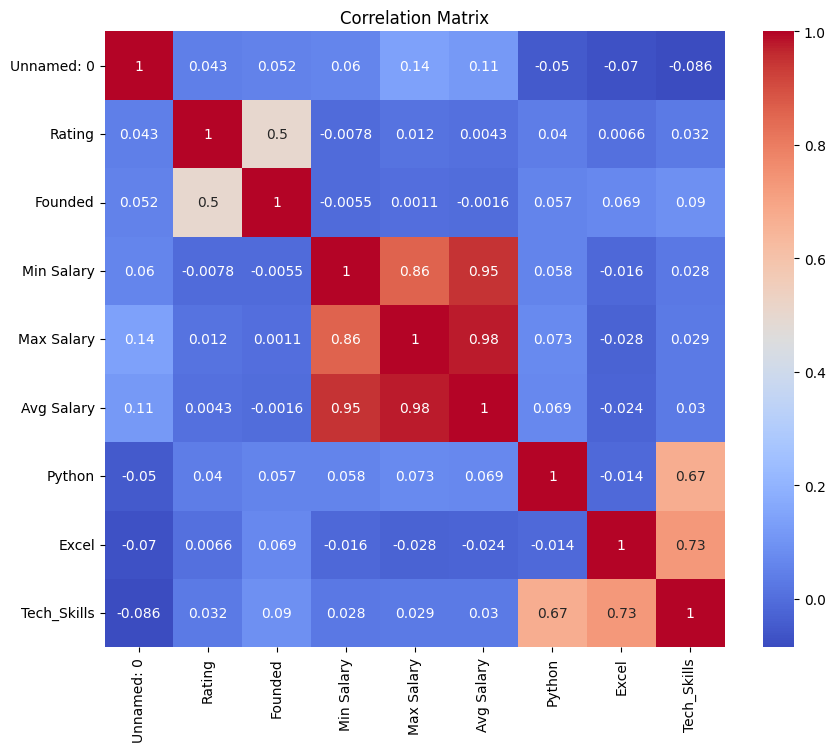

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

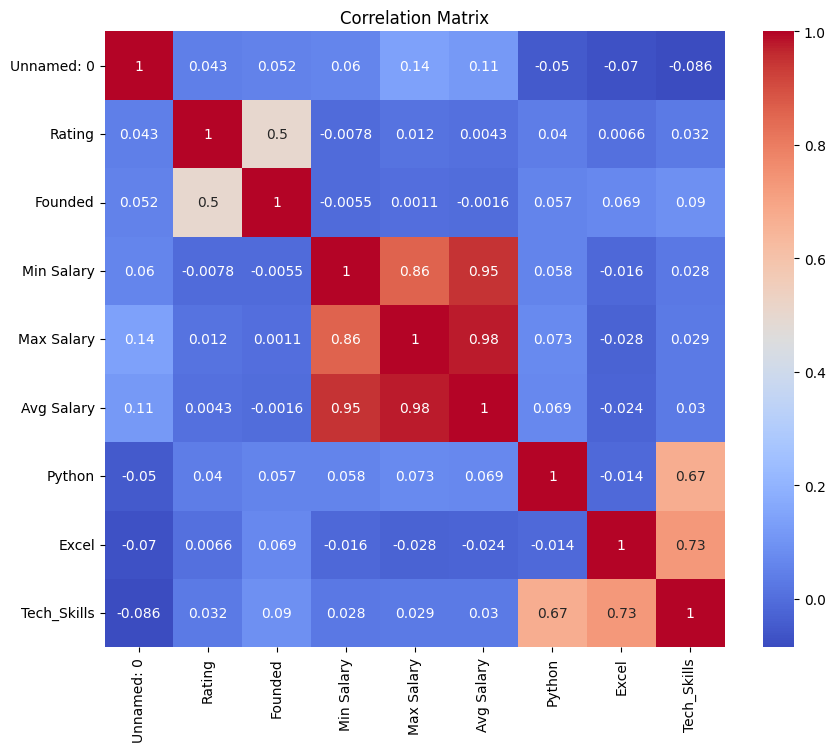

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Map 'Size' to numerical values
size_mapping = {
    '1 to 50 employees': 25,
    '51 to 200 employees': 125,
    '201 to 500 employees': 350,
    '501 to 1000 employees': 750,
    '1001 to 5000 employees': 3000,
    '5001 to 10000 employees': 7500,
    '10000+ employees': 10000,
    '-1': 0, # Assuming -1 means unknown or not applicable, mapped to 0
    'Unknown': 0 # Assuming 'Unknown' means unknown or not applicable, mapped to 0
}
data['Size_Numeric'] = data['Size'].replace(size_mapping).astype(float)


# Define features and target
features = ['Rating', 'Tech_Skills', 'Size_Numeric', 'Founded'] # Use 'Size_Numeric'
X = data[features]
y = data['Avg Salary']

# Ensure all feature columns are numeric before splitting
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')
        # Fill any NaNs that resulted from coercion (e.g., with median or mean)
        X[col].fillna(X[col].median(), inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
# Train model
model = RandomForestRegressor(n_estimators=100,
random_state=42)
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)
# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae}, R2 Score: {r2}")

MAE: 19949.078806740457, R2 Score: -0.15531917039332765


In [ ]:
import streamlit as st
st.title("Data Analyst Job Analysis")
st.write("Average Salary Prediction")
# User input
rating = st.slider("Company Rating", 1, 5, 3)
tech_skills = st.slider("Tech Skills Score", 0, 2, 1)
size = st.selectbox("Company Size", [0, 1, 2])
founded = st.number_input("Year Founded", min_value=1900,
max_value=2023, value=2000)
# Predict
prediction = model.predict([[rating, tech_skills, size,
founded]])
st.write(f"Predicted Salary: ${prediction[0]:,.2f}")

2025-11-17 08:26:07.454 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-17 08:26:07.456 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-17 08:26:07.457 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-17 08:26:07.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-17 08:26:07.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-17 08:26:07.461 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-17 08:26:07.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-17 08:26:07.464 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!pip install streamlit

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

In [ ]:
data_analyst_jobs = pd.read_csv('/content/data_analyst_jobs.csv')

In [ ]:
# replacing Job Titles to avoid duplicates
data_analyst_jobs['Job Title'] = \
    data_analyst_jobs['Job Title'].replace([
        'Sr. Data Analyst',
        'sr. data analyst',
        'Sr Data Analyst',
        'sr data analyst',
        'senior data analyst',
        'Senior Data Analyst',
        'Data Analyst III',
        'data analyst iii',
        'senior data analyst'
    ],
    'Senior Data Analyst', regex=True)
data_analyst_jobs['Job Title'] = \
    data_analyst_jobs['Job Title'].replace([
        'Data Analyst I',
        'data analyst i',
        'Data Analyst Junior',
        'data analyst junior',
        'Junior Data Analyst',
        'Junior Data AnalystI',
        'Junior Data Analystl'
    ],
    'Junior Data Analyst', regex=True)
data_analyst_jobs['Job Title'] = \
    data_analyst_jobs['Job Title'].replace([
        'Data Analyst II',
        'data analyst ii',
        'Middle Data Analyst'
    ],
    'Middle Data Analyst', regex=True)

In [ ]:
data_analyst_jobs.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [ ]:
# replacing Job Titles to avoid duplicates
data_analyst_jobs['Job Title'] = \
    data_analyst_jobs['Job Title'].replace([
        'Sr. Data Analyst',
        'sr. data analyst',
        'Sr Data Analyst',
        'sr data analyst',
        'senior data analyst',
        'Senior Data Analyst',
        'Data Analyst III',
        'data analyst iii',
        'senior data analyst'
    ],
    'Senior Data Analyst', regex=True)
data_analyst_jobs['Job Title'] = \
    data_analyst_jobs['Job Title'].replace([
        'Data Analyst I',
        'data analyst i',
        'Data Analyst Junior',
        'data analyst junior',
        'Junior Data Analyst',
        'Junior Data AnalystI',
        'Junior Data Analystl'
    ],
    'Junior Data Analyst', regex=True)
data_analyst_jobs['Job Title'] = \
    data_analyst_jobs['Job Title'].replace([
        'Data Analyst II',
        'data analyst ii',
        'Middle Data Analyst'
    ],
    'Middle Data Analyst', regex=True)

In [ ]:
# plot the most commmon types of jobs
to_plot = data_analyst_jobs['Job Title'].value_counts()[:5]
# ax = to_plot.plot(kind='bar',
# color=sns.color_palette('Spectral'))
to_plot

,count
Job Title,
Data Analyst,405
Senior Data Analyst,131
Junior Data Analyst,75
Business Data Analyst,28
Data Quality Analyst,17


In [ ]:
## Changing Salary column to int for better calculation
data_analyst_jobs[['MinSalary', 'MaxSalary']] = \
    data_analyst_jobs['Salary Estimate'].str.extract(r'\$(\d+)K-\$(\d+)K')
data_analyst_jobs['MinSalary'] = pd.to_numeric(data_analyst_jobs['MinSalary'])
data_analyst_jobs['MaxSalary'] = pd.to_numeric(data_analyst_jobs['MaxSalary'])

In [ ]:
# changing format to float
data_analyst_jobs['MinSalary'] = data_analyst_jobs['MinSalary'].astype(float)
data_analyst_jobs['MaxSalary'] = data_analyst_jobs['MaxSalary'].astype(float)
data_analyst_jobs['average_salary'] = (data_analyst_jobs['MaxSalary'] + data_analyst_jobs['MinSalary']) / 2
#drop salary estimate(unuseful column)
data_analyst_jobs.drop(['Salary Estimate', 'MinSalary', 'MaxSalary'], axis=1, inplace=True)

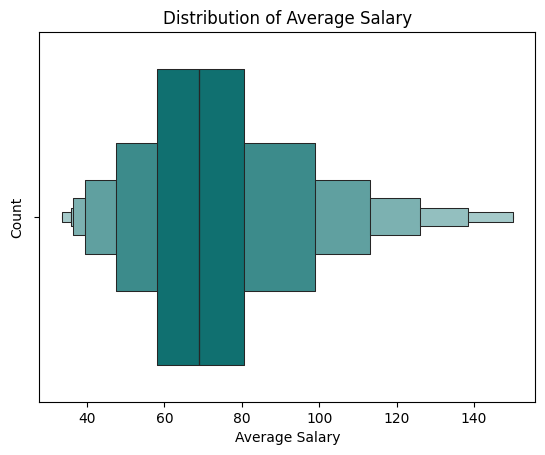

In [739]:
# Average Salary
sns.boxenplot(data=data_analyst_jobs, x='average_salary', color='teal')
plt.xlabel('Average Salary')
plt.ylabel('Count')
plt.title('Distribution of Average Salary')
plt.show()

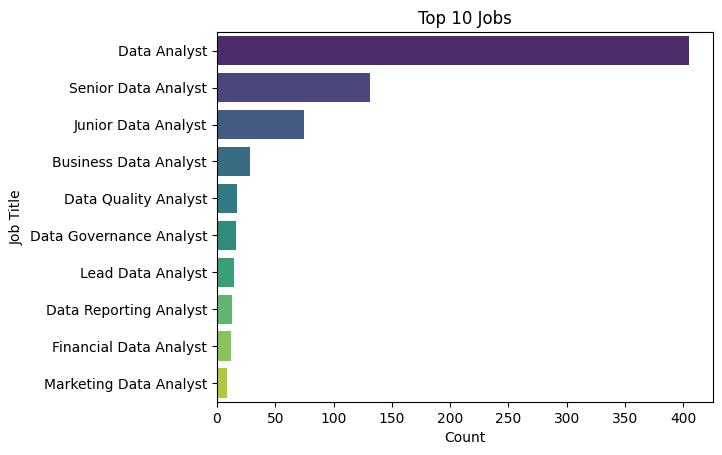

In [ ]:
top_jobs = data_analyst_jobs['Job Title'].value_counts().head(10)
sns.barplot(x=top_jobs.values, y=top_jobs.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.title('Top 10 Jobs')
plt.show()

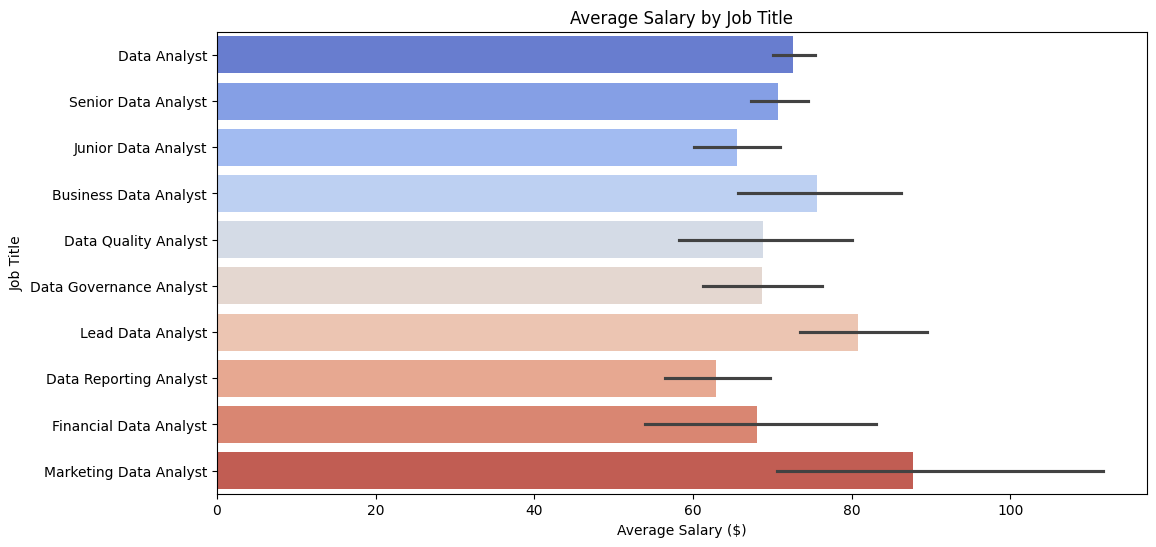

In [ ]:
# Salary and Job Title
data_analyst_jobs_sorted = data_analyst_jobs.sort_values(by='average_salary', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='average_salary', y='Job Title', data=data_analyst_jobs_sorted, orient='h',
order=data_analyst_jobs_sorted['Job Title'].value_counts().head(10).index, palette='coolwarm')
plt.xlabel('Average Salary ($)')
plt.ylabel('Job Title')
plt.title('Average Salary by Job Title')
plt.show()

In [742]:
# Salary trends by location
job_location = data_analyst_jobs.groupby('Location')["average_salary"].mean().reset_index()
top_10 = job_location.sort_values(by="average_salary", ascending=False).head(10)
fig = px.bar(top_10, x='average_salary', y='Location', orientation='h', title='Salary Trends by Location', color="Location", color_continuous_scale=px.colors.sequential.Greens)
fig.update_layout(xaxis_title='AVG Salary (USD)', yaxis_title='Location', showlegend=False)
fig.show()

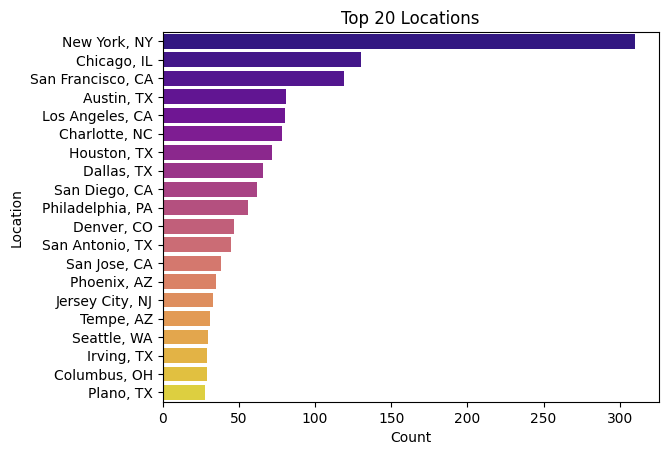

In [ ]:
# Top work locations among interviewed
top_locations = data_analyst_jobs['Location'].value_counts().head(20)
sns.barplot(x=top_locations.values, y=top_locations.index, palette='plasma')
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Top 20 Locations')
plt.show()

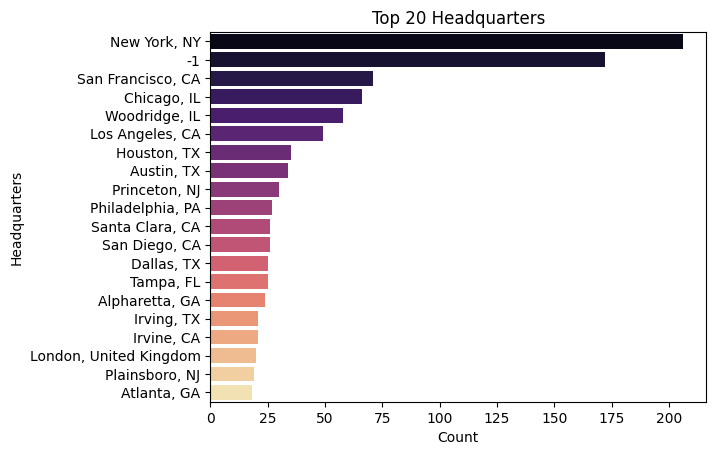

In [ ]:
top_headquarters = data_analyst_jobs['Headquarters'].value_counts().head(20)
sns.barplot(x=top_headquarters.values, y=top_headquarters.index, palette='magma')
plt.xlabel('Count')
plt.ylabel('Headquarters')
plt.title('Top 20 Headquarters')
plt.show()

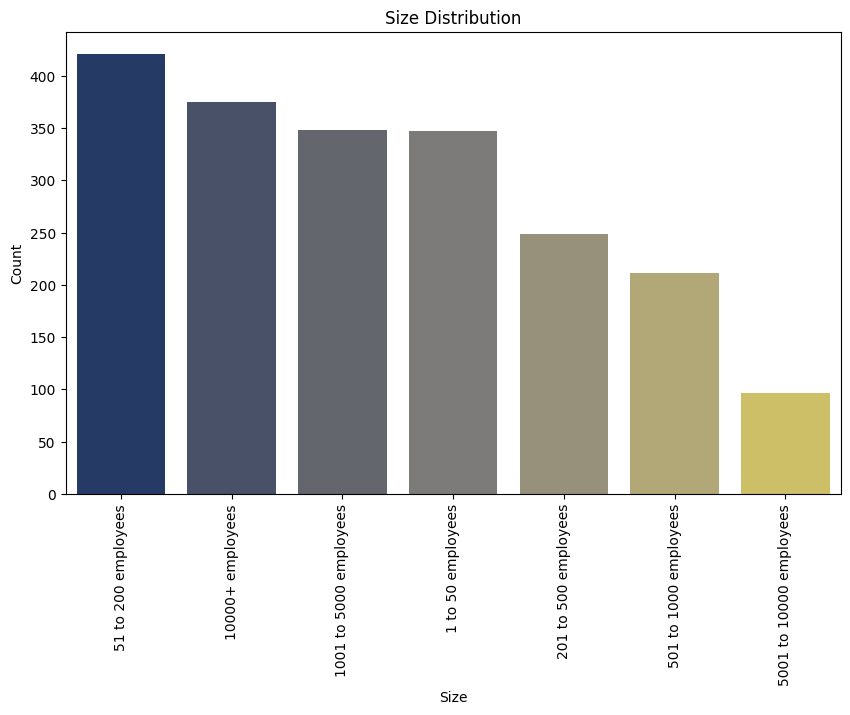

In [ ]:
# Companies by Amount of Employees
filtered_size = data_analyst_jobs[(data_analyst_jobs['Size'] != '-1') & (data_analyst_jobs['Size'] != 'Unknown')]
data_analyst_jobs_size = filtered_size['Size'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=data_analyst_jobs_size.index, y=data_analyst_jobs_size.values, palette='cividis')
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Size Distribution')
plt.xticks(rotation=90)
plt.show()

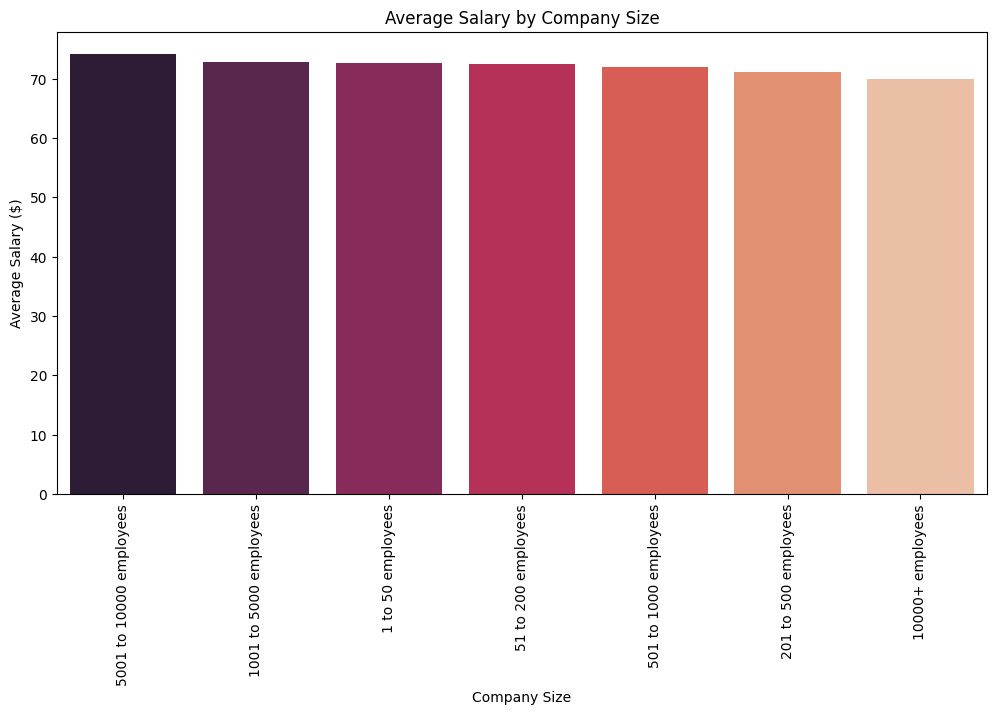

In [ ]:
# Salary by Company Size
data_analyst_jobs_filtered = \
data_analyst_jobs[(data_analyst_jobs['Size'] != '-1') & \
(data_analyst_jobs['Size'] != 'Unknown')]
data_analyst_jobs_sizeXsalary = \
data_analyst_jobs_filtered.groupby('Size')['average_salary'].mean().reset_index()
# Sort the DataFrame by 'AverageSalary' in descending order
data_analyst_jobs_sizeXsalary = \
data_analyst_jobs_sizeXsalary.sort_values(by='average_salary',\
ascending=False)
# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Size', y='average_salary', \
data=data_analyst_jobs_sizeXsalary, palette='rocket')
plt.xlabel('Company Size')
plt.ylabel('Average Salary ($)')
plt.title('Average Salary by Company Size')
plt.xticks(rotation=90)
plt.show()

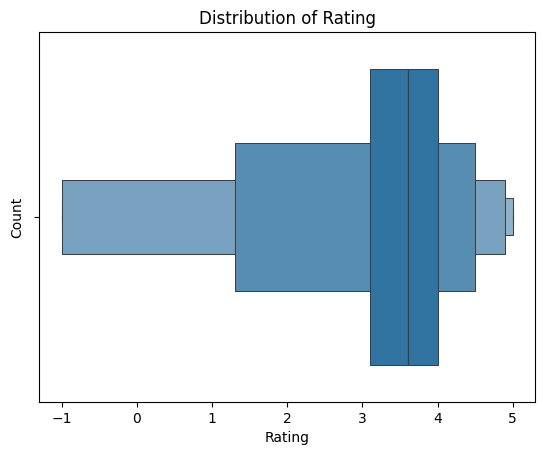

In [ ]:
sns.boxenplot(data=data_analyst_jobs, x='Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Rating')
plt.show()

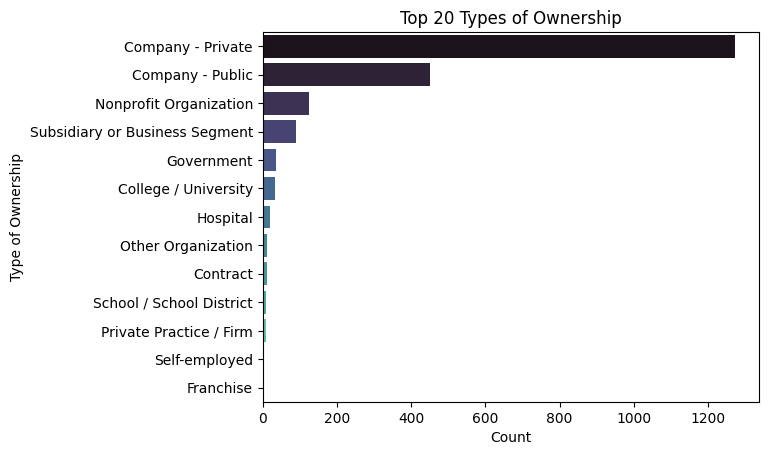

In [ ]:
TOP = data_analyst_jobs[(data_analyst_jobs['Type of ownership']
!= '-1') & (data_analyst_jobs['Type of ownership'] != 'Unknown')]
TOP = TOP['Type of ownership'].value_counts().head(20)
sns.barplot(x=TOP.values, y=TOP.index, palette='mako')
plt.xlabel('Count')
plt.ylabel('Type of Ownership')
plt.title('Top 20 Types of Ownership')
plt.show()

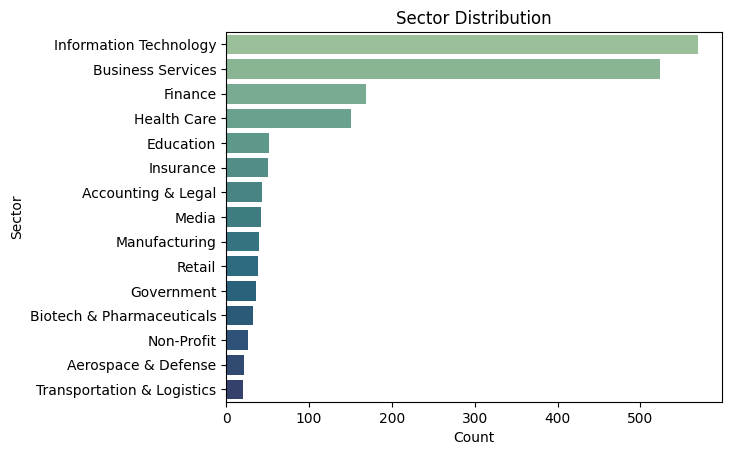

In [ ]:
data_analyst_jobs_sector = data_analyst_jobs[data_analyst_jobs['Sector'] != '-1']['Sector'].value_counts().head(15)
sns.barplot(x=data_analyst_jobs_sector.values,
y=data_analyst_jobs_sector.index, palette='crest')
plt.xlabel('Count')
plt.ylabel('Sector')
plt.title('Sector Distribution')
plt.show()

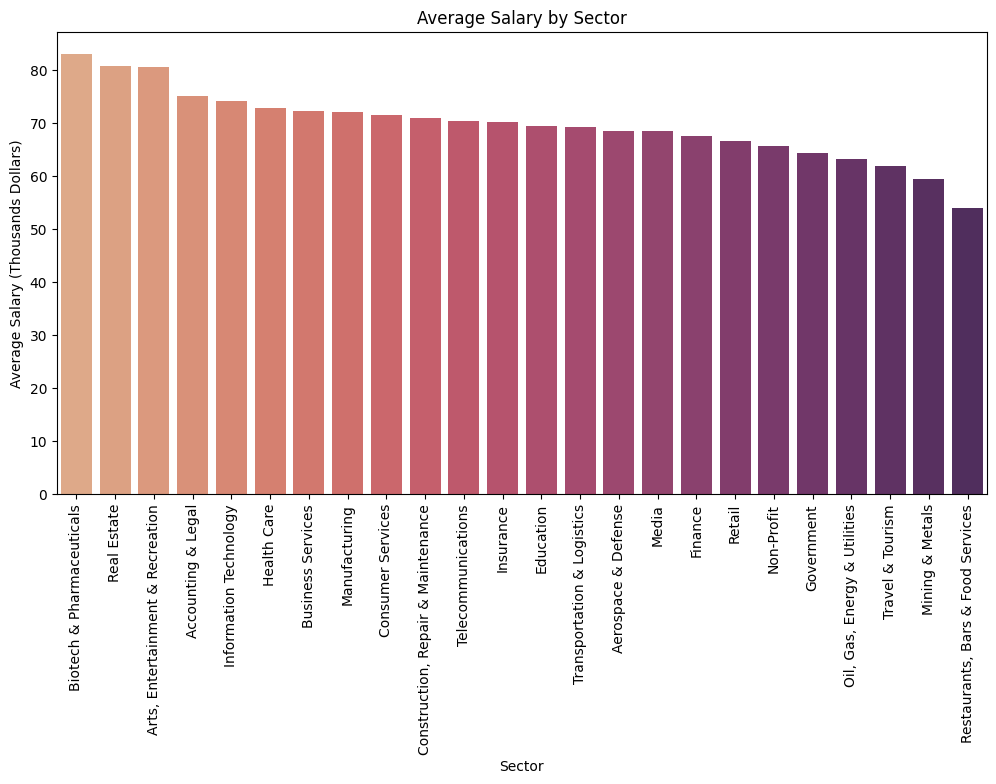

In [ ]:
# Salary by Sector
average_salary_by_sector = data_analyst_jobs[data_analyst_jobs['Sector'] != '-1'].groupby('Sector')['average_salary'].mean().reset_index()
average_salary_by_sector = average_salary_by_sector.sort_values(by='average_salary', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Sector', y='average_salary', data=average_salary_by_sector, palette='flare')
plt.xticks(rotation=90)
plt.xlabel('Sector')
plt.ylabel('Average Salary (Thousands Dollars)')
plt.title('Average Salary by Sector')
plt.show()